In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import holidays

In [175]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.metrics import RMSE,SMAPE
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping,ModelCheckpoint
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import pytorch_lightning as pl

In [58]:
data = pd.read_csv('../traffic/data/1.csv')
data

,service_name,datetime,volumn,packets,unknown
0,service01,2018-07-25 00:00:00,2755201,49886322546,4766059509
1,service01,2018-07-25 00:01:00,2756000,49859101685,4747645421
2,service01,2018-07-25 00:02:00,2755897,49878812122,4748030430
3,service01,2018-07-25 00:03:00,2755301,49851370428,4753731716
4,service01,2018-07-25 00:04:00,2756166,49843140981,4742659364
...,...,...,...,...,...
38875,service01,2018-08-20 23:55:00,2789520,47854087962,4660630439
38876,service01,2018-08-20 23:56:00,2788218,47881474848,4683950486
38877,service01,2018-08-20 23:57:00,2789770,47862666882,4648584625
38878,service01,2018-08-20 23:58:00,2788755,47840202650,4645764385


&downarrow; 공휴일 넣는 방법

In [80]:
kr_holidays = holidays.KR()
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = data['datetime']
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 'holiday' if x in kr_holidays else 'non_holiday')
holiday_df
holiday_df[holiday_df['holiday']=='holiday']

,ds,holiday
30240,2018-08-15 00:00:00,holiday
30241,2018-08-15 00:01:00,holiday
30242,2018-08-15 00:02:00,holiday
30243,2018-08-15 00:03:00,holiday
30244,2018-08-15 00:04:00,holiday
...,...,...
31675,2018-08-15 23:55:00,holiday
31676,2018-08-15 23:56:00,holiday
31677,2018-08-15 23:57:00,holiday
31678,2018-08-15 23:58:00,holiday


In [90]:
use_col = ['volumn','datetime']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
# data.rename({'service_name':'group_ids','datetime':'b','volumn':'value','packets':'c','unknown':'d'},axis=1,inplace=True)
# data.drop(columns=['b','c','d'],inplace=True)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['group_ids']=np.tile('0',len(data))
data['time_idx']=np.arange(len(data))
data['value'] = data['value'] * 8 / 1000000
data['datetime'] = pd.to_datetime(data['datetime'])
data["day_of_week"] = data.datetime.dt.dayofweek.astype(str).astype("category")
data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings
data["month"] = data.datetime.dt.month.astype(str).astype("category")  # categories have be strings
data['time'] = np.tile(np.arange(1440),27) #1일이 1440으로 돼있으므로
data['time'] = data['time'].astype(str).astype("category") # numpy에 astype적용시 적용이 안된다
data

/tmp/ipykernel_406705/4036214619.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings


,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
0,2018-07-25 00:00:00,22.041608,0,0,2,30,7,0
1,2018-07-25 00:01:00,22.048000,0,1,2,30,7,1
2,2018-07-25 00:02:00,22.047176,0,2,2,30,7,2
3,2018-07-25 00:03:00,22.042408,0,3,2,30,7,3
4,2018-07-25 00:04:00,22.049328,0,4,2,30,7,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,22.316160,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,22.305744,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,22.318160,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,22.310040,0,38878,0,34,8,1438


In [83]:
# data = (data.merge((data[['date']].drop_duplicates(ignore_index=True)
# .rename_axis('time_idx')).reset_index(), on = ['date']))

In [94]:
data

,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
0,2018-07-25 00:00:00,22.041608,0,0,2,30,7,0
1,2018-07-25 00:01:00,22.048000,0,1,2,30,7,1
2,2018-07-25 00:02:00,22.047176,0,2,2,30,7,2
3,2018-07-25 00:03:00,22.042408,0,3,2,30,7,3
4,2018-07-25 00:04:00,22.049328,0,4,2,30,7,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,22.316160,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,22.305744,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,22.318160,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,22.310040,0,38878,0,34,8,1438


In [202]:
Train_data = data.iloc[:28800]
Test_data = data.iloc[28800:]

In [93]:
encoder_length =1440
prediction_length=10080 # encoding 기간은 1일 prediction 기간은 7일

In [176]:
training = TimeSeriesDataSet(
    data=Train_data,
    max_encoder_length = encoder_length,
    min_encoder_length=1,
    max_prediction_length = prediction_length,
    min_prediction_length=1,
    target = 'value',
    group_ids = ['group_ids'],
    time_idx = 'time_idx',
    time_varying_known_categoricals=["week_of_year", "day_of_week","month","time"],
    time_varying_unknown_reals = ['value'],
    time_varying_known_reals = ['time_idx'],
    add_relative_time_idx = True,  # add as feature
    add_target_scales = True,  # add as feature
    add_encoder_length = True,  # add as feature
    categorical_encoders={
        'week_of_year':NaNLabelEncoder(add_nan=True),
        'day_of_week':NaNLabelEncoder(add_nan=True),
        'month':NaNLabelEncoder(add_nan=True),
        'time':NaNLabelEncoder(add_nan=True)
    }
)

In [152]:
batch_size = 2
train_dataloader = training.to_dataloader(train=False, batch_size = batch_size,num_workers = 5)

In [162]:
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping
import pytorch_lightning as pl
early_stopping = EarlyStopping(monitor = 'train_loss', min_delta = 1e-2,
                               patience = 3, verbose = True, mode = "min")
checkpoint_callback = ModelCheckpoint(
            monitor='train_loss',
            dirpath='./my/path1',
            filename='{epoch:03d}-{train_loss:.2f}',
            save_top_k=2
        )
#Custom Checkpoint 사용해보기

trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val=0.1,
    max_epochs=30,
    callbacks=[early_stopping,checkpoint_callback]
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


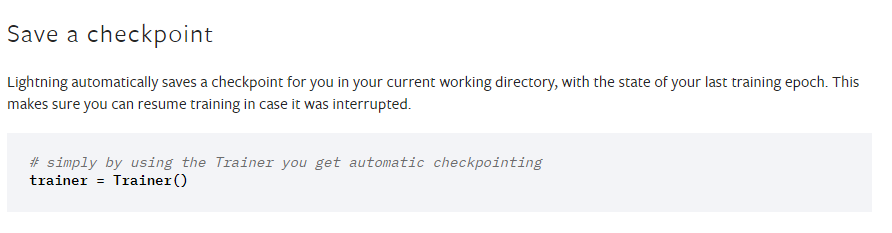
Trainer는 자동으로 Checkpoint를 저장해준다

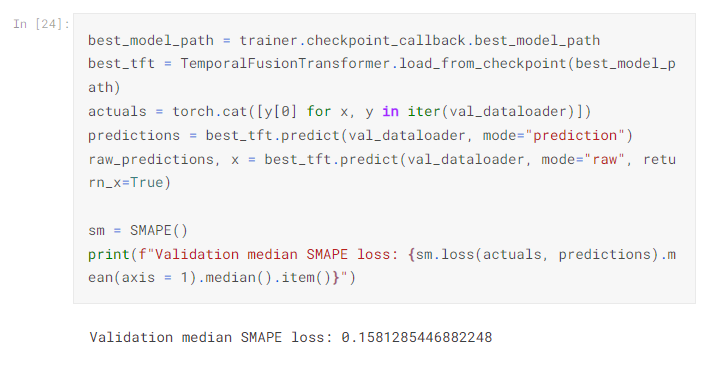

In [163]:
tft = TemporalFusionTransformer.from_dataset(training,
                                             lstm_layers=2,
                                             optimizer = 'adam',
                                             learning_rate=0.012,
                                             hidden_size=16,
                                             attention_head_size=2,
                                             time_varying_reals_encoder=["value"],
                                             time_varying_reals_decoder=["time_idx"],
                                             output_size = 1,
                                             loss=SMAPE()
                                             )

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [164]:
import torch

In [165]:
DEVICE = torch.device("cuda:0")

In [166]:
tft.to(DEVICE)

TemporalFusionTransformer(
  	"attention_head_size":               2
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {'month': {'7': 0, '8': 1}, 'week_of_year': {'30': 0, '31': 1, '32': 2, '33': 3}, 'day_of_week': {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}, 'time': {'0': 0, '1': 1, '10': 2, '100': 3, '1000': 4, '1001': 5, '1002': 6, '1003': 7, '1004': 8, '1005': 9, '1006': 10, '1007': 11, '1008': 12, '1009': 13, '101': 14, '1010': 15, '1011': 16, '1012': 17, '1013': 18, '1014': 19, '1015': 20, '1016': 21, '1017': 22, '1018': 23, '1019': 24, '102': 25, '1020': 26, '1021': 27, '1022': 28, '1023': 29, '1024': 30, '1025': 31, '1026': 32, '1027': 33, '1028': 34, '1029': 35, '103': 36, '1030': 37, '1031': 38, '1032': 39, '1033': 40, '1034': 41, '1035': 42, '1036': 43, '1037': 44, '1038': 45, '1039': 46, '104': 47, '1040': 48, '1041': 49, '1042': 50, '1043'

In [167]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

Epoch 0:   6%|▌         | 1127/20159 [10:19<2:54:20,  1.82it/s, loss=0.000254, v_num=65, train_loss_step=0.000251]


In [168]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 23.1 K
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
6  | decoder_variable_selection         | VariableSelectio

Epoch 0: 100%|██████████| 20159/20159 [2:07:45<00:00,  2.63it/s, loss=0.000141, v_num=66, train_loss_step=0.00014]   

Metric train_loss improved. New best score: 0.000


Epoch 1:   0%|          | 0/20159 [00:00<?, ?it/s, loss=0.000141, v_num=66, train_loss_step=0.00014, train_loss_epoch=0.00019]              

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:447: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(


Epoch 3: 100%|██████████| 20159/20159 [2:07:46<00:00,  2.63it/s, loss=0.000181, v_num=66, train_loss_step=0.000177, train_loss_epoch=0.00026]   

Monitored metric train_loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 3: 100%|██████████| 20159/20159 [2:07:47<00:00,  2.63it/s, loss=0.000181, v_num=66, train_loss_step=0.000177, train_loss_epoch=0.000193]


In [169]:
best_model_path = trainer.checkpoint_callback.best_model_path

In [170]:
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [44]:
Train_data['value'].iloc[-1]

22.429608

In [192]:
new_decoder_data

,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
28800,2018-08-14 00:00:00,22.429608,0,28800,1,33,8,0
28801,2018-08-14 00:01:00,22.429608,0,28801,1,33,8,1
28802,2018-08-14 00:02:00,22.429608,0,28802,1,33,8,2
28803,2018-08-14 00:03:00,22.429608,0,28803,1,33,8,3
28804,2018-08-14 00:04:00,22.429608,0,28804,1,33,8,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,22.429608,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,22.429608,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,22.429608,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,22.429608,0,38878,0,34,8,1438


In [197]:
new_encoder_data = Train_data.iloc[encoder_length:]
new_decoder_data = Test_data
new_decoder_data['value'] = np.repeat(Train_data['value'].iloc[-1],len(new_decoder_data))
new_decoder_data.loc[38880-1440:38880,'week_of_year']=np.repeat('33',1440)
# NaNLabelEncoder(add_nan=True)를 추가해주지 않아서 다음과 같이 수정
# 예측에 유의미한 column으로 보이진 않음
new_decoder_data

/tmp/ipykernel_406705/3054821881.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_decoder_data['value'] = np.repeat(Train_data['value'].iloc[-1],len(new_decoder_data))


,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
28800,2018-08-14 00:00:00,22.429608,0,28800,1,33,8,0
28801,2018-08-14 00:01:00,22.429608,0,28801,1,33,8,1
28802,2018-08-14 00:02:00,22.429608,0,28802,1,33,8,2
28803,2018-08-14 00:03:00,22.429608,0,28803,1,33,8,3
28804,2018-08-14 00:04:00,22.429608,0,28804,1,33,8,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,22.429608,0,38875,0,33,8,1435
38876,2018-08-20 23:56:00,22.429608,0,38876,0,33,8,1436
38877,2018-08-20 23:57:00,22.429608,0,38877,0,33,8,1437
38878,2018-08-20 23:58:00,22.429608,0,38878,0,33,8,1438


In [198]:
new_prediction_data = pd.concat([new_encoder_data,new_decoder_data],ignore_index=True,axis=0)
new_raw_pred=best_model.predict(new_prediction_data , mode='prediction',return_x=False)

In [200]:
pred = np.array(new_raw_pred.view(-1))
print(len(pred))

10080


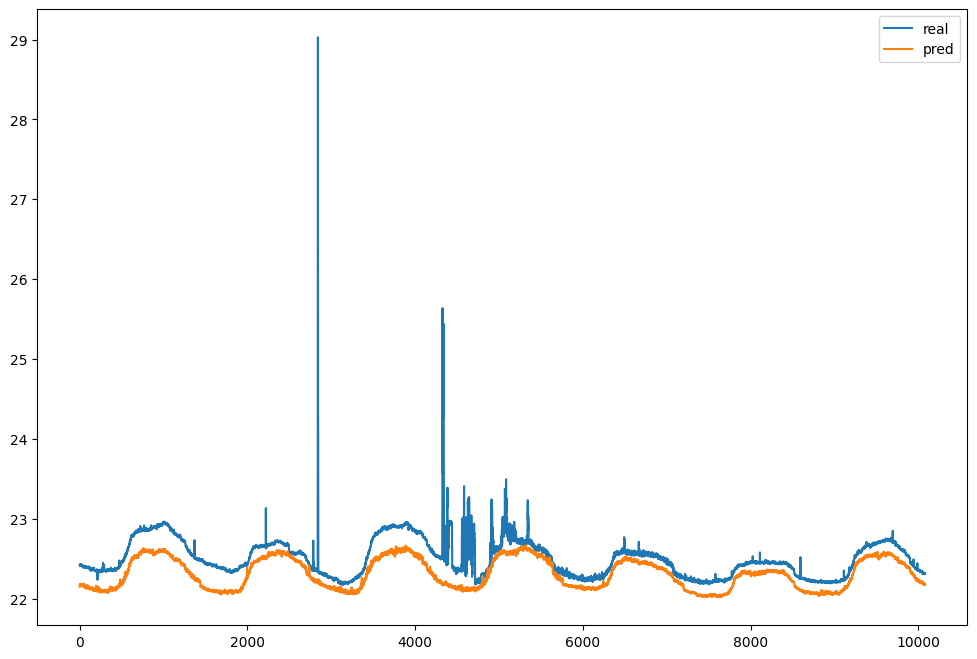

In [203]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),Test_data['value'],label='real')
axes.plot(np.arange(1,10081),pred,label='pred')
plt.legend()

In [235]:
actuals = [Test_data['value'].values]
actuals = torch.tensor(actuals)
pred_list = pred
predictions = torch.tensor(pred_list).view(1,-1)
print('smape',SMAPE()(predictions,actuals).item()*100,'%')# Tensor로 바꿔서 SMAPE 계산해야함
print('rmse',RMSE()(predictions,actuals).item())# Tensor로 바꿔서 RMSE 계산해야함

smape 0.8839137852191925 %
rmse 0.26520660519599915


In [233]:
pred

array([22.148458, 22.169603, 22.174408, ..., 22.185114, 22.173689,
       22.17214 ], dtype=float32)